In [17]:
import uproot
import numpy as np
import pandas as pd
import h5py
import os

VARS = ['ll_mass', 
        'll_eta',
        'll_phi',
        'll_pt',
                  
        "jj_mass",
            "jj_pt"  ,
            "jj_eta" ,
            "jj_phi" ,
            
            "lljj_mass",   
            "lljj_pt"  ,   
            "lljj_eta" ,
            "lljj_phi" ,
            
            "leading_lepton_pt"       ,
            "leading_lepton_eta"      ,
            "leading_lepton_phi"      ,
            "leading_lepton_charge"   ,
            "leading_lepton_mass"     ,
            "subleading_lepton_pt"    ,
            "subleading_lepton_eta"   ,
            "subleading_lepton_phi"   ,
            "subleading_lepton_charge",
            "subleading_lepton_mass"  ,
            
            "dEta_2lep",
            "dPhi_2lep",
            "dRmm_2lep",
            
            #"dEta_jj"    ,
            "dEta_jj_abs",
            "dPhi_jj"    ,
            #??"dPhi_jj_mod"    : (op.deltaPhi(jets[0].p4, jets[1].p4) + np.pi) % (2 * np.pi) - np.pi,
            #??"dPhi_jj_mod_abs": op.abs((op.deltaPhi(jets[0].p4, jets[1].p4) + np.pi) % (2 * np.pi) - np.pi),
            
            "leading_jet_pt"    ,
            "leading_jet_phi"   ,
            "leading_jet_eta"   ,
            "subleading_jet_pt" ,
            "subleading_jet_eta",
            "subleading_jet_phi"
       ]

seed = 7
np.random.seed(seed)

treename = "Hmumu_VBF"
filename = {}
upfile = {}
df = {}

outputPath = '/eos/user/y/yulou/DNN_VBF/12-12_VBF-ttb/' # Todo add path to your bamboo dir 
skimFile = os.path.join(outputPath,'MuMu_VBF_SR_DY1-ttb.parquet')
#yamlFile = os.path.join(outputPath,'plots.yml')

df = pd.read_parquet(skimFile)

#df = pd.read_parquet(skimFile, columns=columns_to_read)

to_keep = [
    "VBFHto2Mu_M-125_TuneCP5_13p6TeV_powheg-pythia8_2023BPix.root",
    "VBFHto2Mu_M-125_TuneCP5_13p6TeV_powheg-pythia8_2023.root",
    "VBFHto2Mu_M-125_TuneCP5_withDipoleRecoil_13p6TeV_powheg-pythia8_2022.root",
    "VBFHto2Mu_M-125_TuneCP5_withDipoleRecoil_13p6TeV_powheg-pythia8_2022EE.root",
    "DY+jets",
    "EWK",
    "tt"
]

df = df[df['process'].isin(to_keep)]

def assign_label(row):
    if row['process'].startswith('VBFHto2Mu_M-125'):
        return 'VBF'
    elif row['process'] in ['EWK', 'DY+jets','tt']:
        return 'bkg' 
    else:
        return "error!" 

df['label'] = df.apply(assign_label, axis=1)

df = df[VARS + ['label']]
df['isSignal'] = np.where(df['label'] == 'VBF', 1, 0)

df = df[(df[VARS[0]] > -999) & (df[VARS[1]] > -999)]
df = df[(df['ll_mass'] > 115) & (df['ll_mass'] < 135)]
#df = df.drop('label', axis=1)
print(df)

          ll_mass    ll_eta    ll_phi       ll_pt      jj_mass       jj_pt  \
0      123.553490  1.627294  2.192517   54.393486   700.426453   47.047043   
1      125.464111  0.973120  2.521122   92.660820   605.361694  116.358124   
2      125.900757  1.754117  2.551011  144.644943   771.901123  194.007858   
3      124.716187  1.612842  1.182548   42.536972  1824.461670   16.866776   
4      124.632584  2.311082  1.965952   36.759472  2529.891602   60.082069   
...           ...       ...       ...         ...          ...         ...   
30598  116.552864  0.114996  1.623403  210.989700   722.953430  220.707458   
30600  119.254738  0.695735  3.042336  161.218658   577.260803  185.541550   
30604  116.824654  2.028286  0.036794  390.664124  1090.725586  241.603333   
30605  120.116547  0.265020  1.706021  167.893494   803.301331  156.629272   
30607  117.475761  2.018465  1.278396   62.834827   408.543976   84.265602   

         jj_eta    jj_phi    lljj_mass     lljj_pt  ...  dEta_j

## Define the model
We'll start with a dense (fully-connected) NN layer.
Our model will have a single fully-connected hidden layer with the same number of neurons as input variables. 
The weights are initialized using a small Gaussian random number. 
We will switch between linear and tanh activation functions for the hidden layer.
The output layer contains a single neuron in order to make predictions. 
It uses the sigmoid activation function in order to produce a probability output in the range of 0 to 1.

We are using the `binary_crossentropy` loss function during training, a standard loss function for binary classification problems. 
We will optimize the model with the Adam algorithm for stochastic gradient descent and we will collect accuracy metrics while the model is trained.

In [18]:
# baseline keras model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import (
    Input,
    Activation,
    Dense,
    Convolution2D,
    MaxPooling2D,
    Dropout,
    Flatten,
)
from tensorflow.keras import optimizers

NDIM = len(VARS)
inputs = Input(shape=(NDIM,), name="input")

hidden1 = Dense(87, activation='relu', name="hidden1")(inputs)

hidden2 = Dense(44, activation='relu', name="hidden2")(hidden1)
hidden3 = Dense(22, activation='relu', name="hidden3")(hidden2)
hidden4 = Dense(11, activation='relu', name="hidden4")(hidden3)

outputs = Dense(1, activation='sigmoid', name="output")(hidden4)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional_103"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden1 (Dense)                 │ (None, 87)             │         2,958 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2 (Dense)                 │ (None, 44)             │         3,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden3 (Dense)                 │ (None, 22)             │           990 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden4 (Dense)                 │ (None, 11)             │           253 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,085 (31.58 KB)

 Trainable params: 8,085 (31.58 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:

df_all =  df.drop('label', axis=1)
dataset = df_all.values
X = dataset[:, 0:NDIM]
Y = dataset[:, NDIM]

from sklearn.model_selection import train_test_split

X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=7)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train_val)
X_train_val = scaler.transform(X_train_val)
X_test = scaler.transform(X_test)#此处的处理可能和bamboo不一样

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor="val_loss", patience=10)

from tensorflow.keras.callbacks import ModelCheckpoint

model_checkpoint = ModelCheckpoint(
    "Keras_BYS_dense_model_115-135.keras",
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    #period=1,
    save_freq='epoch',
)

In [20]:
# Train classifier
import time

begt = time.time()
history = model.fit(
    X_train_val,
    Y_train_val,
    epochs=100,
    batch_size=1024,
    verbose=0,  # switch to 1 for more verbosity
    callbacks=[early_stopping, model_checkpoint],
    validation_split=0.25,
)
print("Finished in {}s".format(time.time() - begt))

Finished in 92.57498383522034s


In [ ]:
# optimize the structure

In [21]:
import sys
sys.path.append('/eos/user/y/yulou/scikit-optimize')
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args


def build_custom_model(num_hiddens=2, initial_node=50, dropout=0.5):
    inputs = Input(shape=(NDIM,), name="input")
    hidden = None
    for i in range(num_hiddens):
        hidden = Dense(int(round(initial_node / np.power(2, i))), activation="relu")(
            inputs if i == 0 else hidden
        )
        hidden = Dropout(np.float32(dropout))(hidden)
    outputs = Dense(1, name="output", kernel_initializer="normal", activation="sigmoid")(hidden)
    model = Model(inputs=inputs, outputs=outputs)

    return model


def train(batch_size=1000):
    history = model.fit(
        X_train_val,
        Y_train_val,
        epochs=100,
        batch_size=batch_size,
        verbose=0,  # switch to 1 for more verbosity
        callbacks=[early_stopping, model_checkpoint],
        validation_split=0.25,
    )
    best_acc = max(history.history["val_accuracy"])
    return best_acc


space = [
    Integer(1, 5, name="hidden_layers"),#(1,5)
    Integer(5, 100, name="initial_nodes"),
    Real(0.0, 0.9, name="dropout"),
    Integer(500, 5000, name="batch_size"),
    Real(10**-5, 10**-1, "log-uniform", name="learning_rate"),
]


@use_named_args(space)
def objective(**X):
    print("New configuration: {}".format(X))

    model = build_custom_model(
        num_hiddens=X["hidden_layers"], initial_node=X["initial_nodes"], dropout=X["dropout"]
    )

    model.compile(
        optimizer=optimizers.Adam(learning_rate=X["learning_rate"]),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    model.summary()

    best_acc = train(batch_size=X["batch_size"])

    print("Best acc: {}".format(best_acc))
    return -best_acc


begt = time.time()
res_gp = gp_minimize(objective, space, n_calls=50, random_state=3)
print("Finish optimization in {}s".format(time.time() - begt))

New configuration: {'hidden_layers': 1, 'initial_nodes': 85, 'dropout': 0.10919572308469448, 'batch_size': 3062, 'learning_rate': 0.0005600770399424082}


Model: "functional_105"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_149 (Dense)               │ (None, 85)             │         2,890 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_149 (Dropout)           │ (None, 85)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            86 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,976 (11.62 KB)

 Trainable params: 2,976 (11.62 KB)

 Non-trainable params: 0 (0.00 B)

Best acc: 0.9219879508018494
New configuration: {'hidden_layers': 1, 'initial_nodes': 9, 'dropout': 0.22309946750343207, 'batch_size': 921, 'learning_rate': 0.006015816920825814}


Model: "functional_107"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_150 (Dense)               │ (None, 9)              │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_150 (Dropout)           │ (None, 9)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            10 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 316 (1.23 KB)

 Trainable params: 316 (1.23 KB)

 Non-trainable params: 0 (0.00 B)

Best acc: 0.921575665473938
New configuration: {'hidden_layers': 2, 'initial_nodes': 48, 'dropout': 0.19401930757342695, 'batch_size': 2093, 'learning_rate': 0.000934423388378717}


Model: "functional_109"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_151 (Dense)               │ (None, 48)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_151 (Dropout)           │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_152 (Dense)               │ (None, 24)             │         1,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_152 (Dropout)           │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,833 (11.07 KB)

 Trainable params: 2,833 (11.07 KB)

 Non-trainable params: 0 (0.00 B)

Best acc: 0.9218000769615173
New configuration: {'hidden_layers': 5, 'initial_nodes': 78, 'dropout': 0.8762834402421655, 'batch_size': 2311, 'learning_rate': 0.001625877427086297}


Model: "functional_111"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_153 (Dense)               │ (None, 78)             │         2,652 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_153 (Dropout)           │ (None, 78)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_154 (Dense)               │ (None, 39)             │         3,081 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_154 (Dropout)           │ (None, 39)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_155 (Dense)               │ (None, 20)             │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_155 (Dropout)           │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_156 (Dense)               │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_156 (Dropout)           │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_157 (Dense)               │ (None, 5)              │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_157 (Dropout)           │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,804 (26.58 KB)

 Trainable params: 6,804 (26.58 KB)

 Non-trainable params: 0 (0.00 B)

Best acc: 0.9214138984680176
New configuration: {'hidden_layers': 2, 'initial_nodes': 61, 'dropout': 0.2474280963926089, 'batch_size': 2546, 'learning_rate': 0.010731513601673246}


Model: "functional_113"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_158 (Dense)               │ (None, 61)             │         2,074 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_158 (Dropout)           │ (None, 61)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_159 (Dense)               │ (None, 30)             │         1,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_159 (Dropout)           │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,965 (15.49 KB)

 Trainable params: 3,965 (15.49 KB)

 Non-trainable params: 0 (0.00 B)

Best acc: 0.9214348196983337
New configuration: {'hidden_layers': 4, 'initial_nodes': 29, 'dropout': 0.8037585947601061, 'batch_size': 3733, 'learning_rate': 1.2090882997080298e-05}


Model: "functional_115"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_160 (Dense)               │ (None, 29)             │           986 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_160 (Dropout)           │ (None, 29)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_161 (Dense)               │ (None, 14)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_161 (Dropout)           │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_162 (Dense)               │ (None, 7)              │           105 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_162 (Dropout)           │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_163 (Dense)               │ (None, 4)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_163 (Dropout)           │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,548 (6.05 KB)

 Trainable params: 1,548 (6.05 KB)

 Non-trainable params: 0 (0.00 B)

Best acc: 0.921142578125
New configuration: {'hidden_layers': 2, 'initial_nodes': 36, 'dropout': 0.7280362834123955, 'batch_size': 2295, 'learning_rate': 0.000499811722314133}


Model: "functional_117"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_164 (Dense)               │ (None, 36)             │         1,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_164 (Dropout)           │ (None, 36)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_165 (Dense)               │ (None, 18)             │           666 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_165 (Dropout)           │ (None, 18)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            19 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,909 (7.46 KB)

 Trainable params: 1,909 (7.46 KB)

 Non-trainable params: 0 (0.00 B)

Best acc: 0.921048641204834
New configuration: {'hidden_layers': 3, 'initial_nodes': 80, 'dropout': 0.6422091724381469, 'batch_size': 604, 'learning_rate': 0.00018326055021161485}


Model: "functional_119"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_166 (Dense)               │ (None, 80)             │         2,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_166 (Dropout)           │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_167 (Dense)               │ (None, 40)             │         3,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_167 (Dropout)           │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_168 (Dense)               │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_168 (Dropout)           │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,801 (26.57 KB)

 Trainable params: 6,801 (26.57 KB)

 Non-trainable params: 0 (0.00 B)

Best acc: 0.9210799336433411
New configuration: {'hidden_layers': 3, 'initial_nodes': 76, 'dropout': 0.5486612987713032, 'batch_size': 1415, 'learning_rate': 0.004116455326627872}


Model: "functional_121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_169 (Dense)               │ (None, 76)             │         2,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_169 (Dropout)           │ (None, 76)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_170 (Dense)               │ (None, 38)             │         2,926 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_170 (Dropout)           │ (None, 38)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_171 (Dense)               │ (None, 19)             │           741 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_171 (Dropout)           │ (None, 19)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            20 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,271 (24.50 KB)

 Trainable params: 6,271 (24.50 KB)

 Non-trainable params: 0 (0.00 B)

Best acc: 0.9211217164993286
New configuration: {'hidden_layers': 4, 'initial_nodes': 88, 'dropout': 0.730104980246572, 'batch_size': 2184, 'learning_rate': 1.9989431770225823e-05}


Model: "functional_123"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_172 (Dense)               │ (None, 88)             │         2,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_172 (Dropout)           │ (None, 88)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_173 (Dense)               │ (None, 44)             │         3,916 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_173 (Dropout)           │ (None, 44)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_174 (Dense)               │ (None, 22)             │           990 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_174 (Dropout)           │ (None, 22)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_175 (Dense)               │ (None, 11)             │           253 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_175 (Dropout)           │ (None, 11)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,163 (31.89 KB)

 Trainable params: 8,163 (31.89 KB)

 Non-trainable params: 0 (0.00 B)

Best acc: 0.9209390878677368
New configuration: {'hidden_layers': 2, 'initial_nodes': 69, 'dropout': 0.6312716485842921, 'batch_size': 556, 'learning_rate': 0.04075135422297446}


Model: "functional_125"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_176 (Dense)               │ (None, 69)             │         2,346 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_176 (Dropout)           │ (None, 69)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_177 (Dense)               │ (None, 34)             │         2,380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_177 (Dropout)           │ (None, 34)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            35 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,761 (18.60 KB)

 Trainable params: 4,761 (18.60 KB)

 Non-trainable params: 0 (0.00 B)

Best acc: 0.9208033680915833
New configuration: {'hidden_layers': 2, 'initial_nodes': 9, 'dropout': 0.005963022874274672, 'batch_size': 4901, 'learning_rate': 0.09873238933393468}


Model: "functional_127"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_178 (Dense)               │ (None, 9)              │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_178 (Dropout)           │ (None, 9)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_179 (Dense)               │ (None, 4)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_179 (Dropout)           │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 351 (1.37 KB)

 Trainable params: 351 (1.37 KB)

 Non-trainable params: 0 (0.00 B)

Best acc: 0.9213147759437561
New configuration: {'hidden_layers': 2, 'initial_nodes': 71, 'dropout': 0.08568743397340406, 'batch_size': 924, 'learning_rate': 1e-05}


Model: "functional_129"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_180 (Dense)               │ (None, 71)             │         2,414 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_180 (Dropout)           │ (None, 71)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_181 (Dense)               │ (None, 36)             │         2,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_181 (Dropout)           │ (None, 36)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            37 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,043 (19.70 KB)

 Trainable params: 5,043 (19.70 KB)

 Non-trainable params: 0 (0.00 B)

Best acc: 0.9212573766708374
New configuration: {'hidden_layers': 4, 'initial_nodes': 12, 'dropout': 0.0340056466587529, 'batch_size': 4254, 'learning_rate': 0.0012960532375285347}


Model: "functional_131"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_182 (Dense)               │ (None, 12)             │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_182 (Dropout)           │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_183 (Dense)               │ (None, 6)              │            78 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_183 (Dropout)           │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_184 (Dense)               │ (None, 3)              │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_184 (Dropout)           │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_185 (Dense)               │ (None, 2)              │             8 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_185 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 518 (2.02 KB)

 Trainable params: 518 (2.02 KB)

 Non-trainable params: 0 (0.00 B)

Best acc: 0.9211008548736572
New configuration: {'hidden_layers': 5, 'initial_nodes': 79, 'dropout': 0.33251427314754145, 'batch_size': 566, 'learning_rate': 1.4058409673437665e-05}


Model: "functional_133"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_186 (Dense)               │ (None, 79)             │         2,686 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_186 (Dropout)           │ (None, 79)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_187 (Dense)               │ (None, 40)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_187 (Dropout)           │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_188 (Dense)               │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_188 (Dropout)           │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_189 (Dense)               │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_189 (Dropout)           │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_190 (Dense)               │ (None, 5)              │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_190 (Dropout)           │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,977 (27.25 KB)

 Trainable params: 6,977 (27.25 KB)

 Non-trainable params: 0 (0.00 B)

Best acc: 0.9212260842323303
New configuration: {'hidden_layers': 3, 'initial_nodes': 50, 'dropout': 0.11494581134597397, 'batch_size': 1361, 'learning_rate': 0.000704742774689105}


Model: "functional_135"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_191 (Dense)               │ (None, 50)             │         1,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_191 (Dropout)           │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_192 (Dense)               │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_192 (Dropout)           │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_193 (Dense)               │ (None, 12)             │           312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_193 (Dropout)           │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,300 (12.89 KB)

 Trainable params: 3,300 (12.89 KB)

 Non-trainable params: 0 (0.00 B)

Best acc: 0.9208138585090637
New configuration: {'hidden_layers': 3, 'initial_nodes': 22, 'dropout': 0.01017481417472015, 'batch_size': 1984, 'learning_rate': 2.6687064331898085e-05}


Model: "functional_137"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_194 (Dense)               │ (None, 22)             │           748 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_194 (Dropout)           │ (None, 22)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_195 (Dense)               │ (None, 11)             │           253 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_195 (Dropout)           │ (None, 11)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_196 (Dense)               │ (None, 6)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_196 (Dropout)           │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,080 (4.22 KB)

 Trainable params: 1,080 (4.22 KB)

 Non-trainable params: 0 (0.00 B)

Best acc: 0.9208190441131592
New configuration: {'hidden_layers': 2, 'initial_nodes': 59, 'dropout': 0.6508338648972894, 'batch_size': 816, 'learning_rate': 0.00057482008733321}


Model: "functional_139"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_197 (Dense)               │ (None, 59)             │         2,006 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_197 (Dropout)           │ (None, 59)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_198 (Dense)               │ (None, 30)             │         1,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_198 (Dropout)           │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,837 (14.99 KB)

 Trainable params: 3,837 (14.99 KB)

 Non-trainable params: 0 (0.00 B)

Best acc: 0.9209912419319153
New configuration: {'hidden_layers': 1, 'initial_nodes': 32, 'dropout': 0.8896649447462678, 'batch_size': 2535, 'learning_rate': 0.00033950172538705823}


Model: "functional_141"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_199 (Dense)               │ (None, 32)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_199 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,121 (4.38 KB)

 Trainable params: 1,121 (4.38 KB)

 Non-trainable params: 0 (0.00 B)

Best acc: 0.9205529093742371
New configuration: {'hidden_layers': 1, 'initial_nodes': 100, 'dropout': 0.02799607645876198, 'batch_size': 2504, 'learning_rate': 0.018025375256181597}


Model: "functional_143"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_200 (Dense)               │ (None, 100)            │         3,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_200 (Dropout)           │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,501 (13.68 KB)

 Trainable params: 3,501 (13.68 KB)

 Non-trainable params: 0 (0.00 B)

Best acc: 0.9205424785614014
New configuration: {'hidden_layers': 2, 'initial_nodes': 52, 'dropout': 0.16917069310228466, 'batch_size': 4126, 'learning_rate': 0.0005212162917712515}


Model: "functional_145"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_201 (Dense)               │ (None, 52)             │         1,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_201 (Dropout)           │ (None, 52)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_202 (Dense)               │ (None, 26)             │         1,378 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_202 (Dropout)           │ (None, 26)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,173 (12.39 KB)

 Trainable params: 3,173 (12.39 KB)

 Non-trainable params: 0 (0.00 B)

Best acc: 0.9202815890312195
New configuration: {'hidden_layers': 1, 'initial_nodes': 27, 'dropout': 0.17367925633729597, 'batch_size': 2337, 'learning_rate': 0.00531088339899474}


Model: "functional_147"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_203 (Dense)               │ (None, 27)             │           918 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_203 (Dropout)           │ (None, 27)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 946 (3.70 KB)

 Trainable params: 946 (3.70 KB)

 Non-trainable params: 0 (0.00 B)

Best acc: 0.9204694032669067
New configuration: {'hidden_layers': 1, 'initial_nodes': 58, 'dropout': 0.4566321072937268, 'batch_size': 3383, 'learning_rate': 1.6811123266237894e-05}


Model: "functional_149"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_204 (Dense)               │ (None, 58)             │         1,972 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_204 (Dropout)           │ (None, 58)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            59 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,031 (7.93 KB)

 Trainable params: 2,031 (7.93 KB)

 Non-trainable params: 0 (0.00 B)

Best acc: 0.9203389883041382
New configuration: {'hidden_layers': 1, 'initial_nodes': 87, 'dropout': 0.12342141454203673, 'batch_size': 3280, 'learning_rate': 0.0011318793505175763}


Model: "functional_151"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_205 (Dense)               │ (None, 87)             │         2,958 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_205 (Dropout)           │ (None, 87)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            88 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,046 (11.90 KB)

 Trainable params: 3,046 (11.90 KB)

 Non-trainable params: 0 (0.00 B)

Best acc: 0.9201980829238892
New configuration: {'hidden_layers': 3, 'initial_nodes': 65, 'dropout': 0.835085214830164, 'batch_size': 3427, 'learning_rate': 0.03061786310762134}


Model: "functional_153"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_206 (Dense)               │ (None, 65)             │         2,210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_206 (Dropout)           │ (None, 65)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_207 (Dense)               │ (None, 32)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_207 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_208 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_208 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,867 (19.01 KB)

 Trainable params: 4,867 (19.01 KB)

 Non-trainable params: 0 (0.00 B)

Best acc: 0.9201250076293945
New configuration: {'hidden_layers': 2, 'initial_nodes': 22, 'dropout': 0.4945045892426006, 'batch_size': 1816, 'learning_rate': 0.05996943318367264}


Model: "functional_155"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_209 (Dense)               │ (None, 22)             │           748 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_209 (Dropout)           │ (None, 22)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_210 (Dense)               │ (None, 11)             │           253 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_210 (Dropout)           │ (None, 11)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,013 (3.96 KB)

 Trainable params: 1,013 (3.96 KB)

 Non-trainable params: 0 (0.00 B)

Best acc: 0.9201563596725464
New configuration: {'hidden_layers': 1, 'initial_nodes': 73, 'dropout': 0.45105647275352984, 'batch_size': 2842, 'learning_rate': 0.0002358159791622593}


Model: "functional_157"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_211 (Dense)               │ (None, 73)             │         2,482 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_211 (Dropout)           │ (None, 73)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            74 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,556 (9.98 KB)

 Trainable params: 2,556 (9.98 KB)

 Non-trainable params: 0 (0.00 B)

Best acc: 0.9199841618537903
New configuration: {'hidden_layers': 1, 'initial_nodes': 26, 'dropout': 0.4911871990137514, 'batch_size': 3108, 'learning_rate': 0.00016117404679657382}


Model: "functional_159"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_212 (Dense)               │ (None, 26)             │           884 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_212 (Dropout)           │ (None, 26)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 911 (3.56 KB)

 Trainable params: 911 (3.56 KB)

 Non-trainable params: 0 (0.00 B)

Best acc: 0.9199162721633911
New configuration: {'hidden_layers': 2, 'initial_nodes': 83, 'dropout': 0.1028431792186256, 'batch_size': 3823, 'learning_rate': 0.024601415902711005}


Model: "functional_161"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_213 (Dense)               │ (None, 83)             │         2,822 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_213 (Dropout)           │ (None, 83)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_214 (Dense)               │ (None, 42)             │         3,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_214 (Dropout)           │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            43 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,393 (24.97 KB)

 Trainable params: 6,393 (24.97 KB)

 Non-trainable params: 0 (0.00 B)

Best acc: 0.9197180271148682
New configuration: {'hidden_layers': 1, 'initial_nodes': 65, 'dropout': 0.21076137525939515, 'batch_size': 551, 'learning_rate': 0.0010474345887518978}


Model: "functional_163"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_215 (Dense)               │ (None, 65)             │         2,210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_215 (Dropout)           │ (None, 65)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,276 (8.89 KB)

 Trainable params: 2,276 (8.89 KB)

 Non-trainable params: 0 (0.00 B)

Best acc: 0.9207720756530762
New configuration: {'hidden_layers': 4, 'initial_nodes': 92, 'dropout': 0.08292402671447585, 'batch_size': 880, 'learning_rate': 0.0001284463690741311}


Model: "functional_165"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_216 (Dense)               │ (None, 92)             │         3,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_216 (Dropout)           │ (None, 92)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_217 (Dense)               │ (None, 46)             │         4,278 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_217 (Dropout)           │ (None, 46)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_218 (Dense)               │ (None, 23)             │         1,081 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_218 (Dropout)           │ (None, 23)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_219 (Dense)               │ (None, 12)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_219 (Dropout)           │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,788 (34.33 KB)

 Trainable params: 8,788 (34.33 KB)

 Non-trainable params: 0 (0.00 B)

Best acc: 0.9203963875770569
New configuration: {'hidden_layers': 2, 'initial_nodes': 53, 'dropout': 0.0061896252061444355, 'batch_size': 3530, 'learning_rate': 0.028650712559343563}


Model: "functional_167"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_220 (Dense)               │ (None, 53)             │         1,802 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_220 (Dropout)           │ (None, 53)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_221 (Dense)               │ (None, 26)             │         1,404 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_221 (Dropout)           │ (None, 26)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,233 (12.63 KB)

 Trainable params: 3,233 (12.63 KB)

 Non-trainable params: 0 (0.00 B)

Best acc: 0.9201667904853821
New configuration: {'hidden_layers': 4, 'initial_nodes': 37, 'dropout': 0.08075566811981615, 'batch_size': 4624, 'learning_rate': 0.0002719075904521167}


Model: "functional_169"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_222 (Dense)               │ (None, 37)             │         1,258 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_222 (Dropout)           │ (None, 37)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_223 (Dense)               │ (None, 18)             │           684 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_223 (Dropout)           │ (None, 18)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_224 (Dense)               │ (None, 9)              │           171 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_224 (Dropout)           │ (None, 9)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_225 (Dense)               │ (None, 5)              │            50 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_225 (Dropout)           │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,169 (8.47 KB)

 Trainable params: 2,169 (8.47 KB)

 Non-trainable params: 0 (0.00 B)

Best acc: 0.9199684858322144
New configuration: {'hidden_layers': 4, 'initial_nodes': 64, 'dropout': 0.1723788677033302, 'batch_size': 1924, 'learning_rate': 0.00015490367189505087}


Model: "functional_171"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_226 (Dense)               │ (None, 64)             │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_226 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_227 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_227 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_228 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_228 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_229 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_229 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,929 (19.25 KB)

 Trainable params: 4,929 (19.25 KB)

 Non-trainable params: 0 (0.00 B)

Best acc: 0.9200780391693115
New configuration: {'hidden_layers': 3, 'initial_nodes': 13, 'dropout': 0.1228116597885839, 'batch_size': 814, 'learning_rate': 2.260617672448488e-05}


Model: "functional_173"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_230 (Dense)               │ (None, 13)             │           442 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_230 (Dropout)           │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_231 (Dense)               │ (None, 6)              │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_231 (Dropout)           │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_232 (Dense)               │ (None, 3)              │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_232 (Dropout)           │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 551 (2.15 KB)

 Trainable params: 551 (2.15 KB)

 Non-trainable params: 0 (0.00 B)

Best acc: 0.9202189445495605
New configuration: {'hidden_layers': 4, 'initial_nodes': 81, 'dropout': 0.01626620943913159, 'batch_size': 1599, 'learning_rate': 0.0022930910520963057}


Model: "functional_175"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_233 (Dense)               │ (None, 81)             │         2,754 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_233 (Dropout)           │ (None, 81)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_234 (Dense)               │ (None, 40)             │         3,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_234 (Dropout)           │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_235 (Dense)               │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_235 (Dropout)           │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_236 (Dense)               │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_236 (Dropout)           │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,075 (27.64 KB)

 Trainable params: 7,075 (27.64 KB)

 Non-trainable params: 0 (0.00 B)

Best acc: 0.91997891664505
New configuration: {'hidden_layers': 5, 'initial_nodes': 95, 'dropout': 0.5779133902952718, 'batch_size': 1613, 'learning_rate': 0.027611475566774714}


Model: "functional_177"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_237 (Dense)               │ (None, 95)             │         3,230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_237 (Dropout)           │ (None, 95)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_238 (Dense)               │ (None, 48)             │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_238 (Dropout)           │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_239 (Dense)               │ (None, 24)             │         1,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_239 (Dropout)           │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_240 (Dense)               │ (None, 12)             │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_240 (Dropout)           │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_241 (Dense)               │ (None, 6)              │            78 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_241 (Dropout)           │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,399 (36.71 KB)

 Trainable params: 9,399 (36.71 KB)

 Non-trainable params: 0 (0.00 B)

Best acc: 0.9199893474578857
New configuration: {'hidden_layers': 3, 'initial_nodes': 99, 'dropout': 0.4252681887763632, 'batch_size': 3060, 'learning_rate': 0.00050016025313788}


Model: "functional_179"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_242 (Dense)               │ (None, 99)             │         3,366 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_242 (Dropout)           │ (None, 99)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_243 (Dense)               │ (None, 50)             │         5,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_243 (Dropout)           │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_244 (Dense)               │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_244 (Dropout)           │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,667 (37.76 KB)

 Trainable params: 9,667 (37.76 KB)

 Non-trainable params: 0 (0.00 B)

Best acc: 0.9198484420776367
New configuration: {'hidden_layers': 1, 'initial_nodes': 85, 'dropout': 0.12277137781814064, 'batch_size': 4967, 'learning_rate': 0.0004370128569096564}


Model: "functional_181"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_245 (Dense)               │ (None, 85)             │         2,890 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_245 (Dropout)           │ (None, 85)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            86 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,976 (11.62 KB)

 Trainable params: 2,976 (11.62 KB)

 Non-trainable params: 0 (0.00 B)

Best acc: 0.9194362163543701
New configuration: {'hidden_layers': 4, 'initial_nodes': 44, 'dropout': 0.14877063342766714, 'batch_size': 4821, 'learning_rate': 0.00868785594006618}


Model: "functional_183"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_246 (Dense)               │ (None, 44)             │         1,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_246 (Dropout)           │ (None, 44)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_247 (Dense)               │ (None, 22)             │           990 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_247 (Dropout)           │ (None, 22)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_248 (Dense)               │ (None, 11)             │           253 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_248 (Dropout)           │ (None, 11)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_249 (Dense)               │ (None, 6)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_249 (Dropout)           │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,818 (11.01 KB)

 Trainable params: 2,818 (11.01 KB)

 Non-trainable params: 0 (0.00 B)

Best acc: 0.919404923915863
New configuration: {'hidden_layers': 3, 'initial_nodes': 9, 'dropout': 0.5617440386546847, 'batch_size': 1029, 'learning_rate': 0.00023493336508358318}


Model: "functional_185"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_250 (Dense)               │ (None, 9)              │           306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_250 (Dropout)           │ (None, 9)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_251 (Dense)               │ (None, 4)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_251 (Dropout)           │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_252 (Dense)               │ (None, 2)              │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_252 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 359 (1.40 KB)

 Trainable params: 359 (1.40 KB)

 Non-trainable params: 0 (0.00 B)

Best acc: 0.9199058413505554
New configuration: {'hidden_layers': 3, 'initial_nodes': 13, 'dropout': 0.027145413981736574, 'batch_size': 1702, 'learning_rate': 0.0034221393046124267}


Model: "functional_187"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_253 (Dense)               │ (None, 13)             │           442 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_253 (Dropout)           │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_254 (Dense)               │ (None, 6)              │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_254 (Dropout)           │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_255 (Dense)               │ (None, 3)              │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_255 (Dropout)           │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 551 (2.15 KB)

 Trainable params: 551 (2.15 KB)

 Non-trainable params: 0 (0.00 B)

Best acc: 0.9196814894676208
New configuration: {'hidden_layers': 5, 'initial_nodes': 5, 'dropout': 0.5055472824546742, 'batch_size': 2767, 'learning_rate': 0.0021817630404394944}


Model: "functional_189"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_256 (Dense)               │ (None, 5)              │           170 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_256 (Dropout)           │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_257 (Dense)               │ (None, 2)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_257 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_258 (Dense)               │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_258 (Dropout)           │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_259 (Dense)               │ (None, 1)              │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_259 (Dropout)           │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_260 (Dense)               │ (None, 0)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_260 (Dropout)           │ (None, 0)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │             1 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 188 (752.00 B)

 Trainable params: 188 (752.00 B)

 Non-trainable params: 0 (0.00 B)

Best acc: 0.9194936156272888
New configuration: {'hidden_layers': 4, 'initial_nodes': 94, 'dropout': 0.5452116863407384, 'batch_size': 2689, 'learning_rate': 0.018260737424443497}


Model: "functional_191"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_261 (Dense)               │ (None, 94)             │         3,196 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_261 (Dropout)           │ (None, 94)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_262 (Dense)               │ (None, 47)             │         4,465 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_262 (Dropout)           │ (None, 47)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_263 (Dense)               │ (None, 24)             │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_263 (Dropout)           │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_264 (Dense)               │ (None, 12)             │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_264 (Dropout)           │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,126 (35.65 KB)

 Trainable params: 9,126 (35.65 KB)

 Non-trainable params: 0 (0.00 B)

Best acc: 0.9194310307502747
New configuration: {'hidden_layers': 2, 'initial_nodes': 56, 'dropout': 0.419724320130531, 'batch_size': 1903, 'learning_rate': 0.0007651683000121115}


Model: "functional_193"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_265 (Dense)               │ (None, 56)             │         1,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_265 (Dropout)           │ (None, 56)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_266 (Dense)               │ (None, 28)             │         1,596 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_266 (Dropout)           │ (None, 28)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            29 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,529 (13.79 KB)

 Trainable params: 3,529 (13.79 KB)

 Non-trainable params: 0 (0.00 B)

Best acc: 0.9195092916488647
New configuration: {'hidden_layers': 2, 'initial_nodes': 20, 'dropout': 0.659168350389802, 'batch_size': 4999, 'learning_rate': 3.1907835848982264e-05}


Model: "functional_195"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_267 (Dense)               │ (None, 20)             │           680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_267 (Dropout)           │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_268 (Dense)               │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_268 (Dropout)           │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 901 (3.52 KB)

 Trainable params: 901 (3.52 KB)

 Non-trainable params: 0 (0.00 B)

Best acc: 0.9195144772529602
New configuration: {'hidden_layers': 1, 'initial_nodes': 50, 'dropout': 0.8049974461766702, 'batch_size': 538, 'learning_rate': 0.048810098057492694}


Model: "functional_197"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_269 (Dense)               │ (None, 50)             │         1,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_269 (Dropout)           │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,751 (6.84 KB)

 Trainable params: 1,751 (6.84 KB)

 Non-trainable params: 0 (0.00 B)

Best acc: 0.9202346205711365
New configuration: {'hidden_layers': 2, 'initial_nodes': 24, 'dropout': 0.2532704170293157, 'batch_size': 1606, 'learning_rate': 0.006050420243776428}


Model: "functional_199"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_270 (Dense)               │ (None, 24)             │           816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_270 (Dropout)           │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_271 (Dense)               │ (None, 12)             │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_271 (Dropout)           │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,129 (4.41 KB)

 Trainable params: 1,129 (4.41 KB)

 Non-trainable params: 0 (0.00 B)

Best acc: 0.9198902249336243
New configuration: {'hidden_layers': 2, 'initial_nodes': 6, 'dropout': 0.8995409798748857, 'batch_size': 4998, 'learning_rate': 0.0013720415242882268}


Model: "functional_201"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_272 (Dense)               │ (None, 6)              │           204 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_272 (Dropout)           │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_273 (Dense)               │ (None, 3)              │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_273 (Dropout)           │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 229 (916.00 B)

 Trainable params: 229 (916.00 B)

 Non-trainable params: 0 (0.00 B)

Best acc: 0.91935795545578
New configuration: {'hidden_layers': 5, 'initial_nodes': 51, 'dropout': 0.004059798458122133, 'batch_size': 2976, 'learning_rate': 0.00040296893142561526}


Model: "functional_203"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_274 (Dense)               │ (None, 51)             │         1,734 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_274 (Dropout)           │ (None, 51)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_275 (Dense)               │ (None, 26)             │         1,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_275 (Dropout)           │ (None, 26)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_276 (Dense)               │ (None, 13)             │           351 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_276 (Dropout)           │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_277 (Dense)               │ (None, 6)              │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_277 (Dropout)           │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_278 (Dense)               │ (None, 3)              │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_278 (Dropout)           │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,546 (13.85 KB)

 Trainable params: 3,546 (13.85 KB)

 Non-trainable params: 0 (0.00 B)

Best acc: 0.9192274808883667
Finish optimization in 869.2745473384857s


## Visualize the improvement
Let's see how Bayesian optimization improves the accuracy

In [22]:
print(
    "Best parameters: \
\nbest_hidden_layers = {} \
\nbest_initial_nodes = {} \
\nbest_dropout = {} \
\nbest_batch_size = {} \
\nbest_learning_rate = {}".format(
        res_gp.x[0], res_gp.x[1], res_gp.x[2], res_gp.x[3], res_gp.x[4]
    )
)

Best parameters: 
best_hidden_layers = 1 
best_initial_nodes = 85 
best_dropout = 0.10919572308469448 
best_batch_size = 3062 
best_learning_rate = 0.0005600770399424082


<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

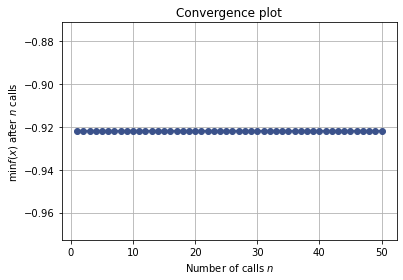

In [23]:
from skopt.plots import plot_convergence

plot_convergence(res_gp)

In [24]:
print(model)

<Functional name=functional_103, built=True>


5989/5989 ━━━━━━━━━━━━━━━━━━━━ 6s 958us/step


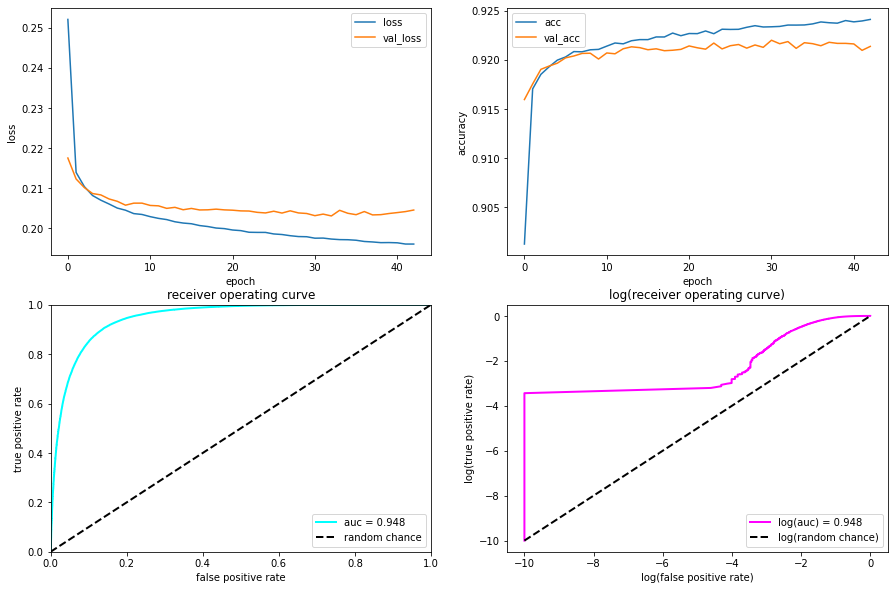

In [25]:
import matplotlib.pyplot as plt

%matplotlib inline
# plot loss vs epoch
plt.figure(figsize=(15, 10))
ax = plt.subplot(2, 2, 1)
ax.plot(history.history["loss"], label="loss")
ax.plot(history.history["val_loss"], label="val_loss")
ax.legend(loc="upper right")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")

# plot accuracy vs epoch
ax = plt.subplot(2, 2, 2)
ax.plot(history.history["accuracy"], label="acc")
ax.plot(history.history["val_accuracy"], label="val_acc")
ax.legend(loc="upper left")
ax.set_xlabel("epoch")
ax.set_ylabel("accuracy")

# Plot ROC
Y_predict = model.predict(X_test)
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
roc_auc = auc(fpr, tpr)
ax = plt.subplot(2, 2, 3)
ax.plot(fpr, tpr, lw=2, color="cyan", label="auc = %.3f" % (roc_auc))
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="k", label="random chance")
ax.set_xlim([0, 1.0])
ax.set_ylim([0, 1.0])
ax.set_xlabel("false positive rate")
ax.set_ylabel("true positive rate")
ax.set_title("receiver operating curve")
ax.legend(loc="lower right")

# Plot log ROC
ax = plt.subplot(2, 2, 4)
fpr_log = np.log10(fpr + 1e-10)
tpr_log = np.log10(tpr + 1e-10)
ax.plot(fpr_log, tpr_log, lw=2, color="magenta", label="log(auc) = %.3f" % (roc_auc))
ax.plot(np.log10([1e-10, 1]), np.log10([1e-10, 1]), linestyle="--", lw=2, color="k", label="log(random chance)")
ax.set_xlabel("log(false positive rate)")
ax.set_ylabel("log(true positive rate)")
ax.set_title("log(receiver operating curve)")
ax.legend(loc="lower right")


plt.show()

In [26]:
df1=df_all.drop('isSignal', axis=1)
scaler = StandardScaler()
scaler.fit_transform(df1) 

X = df1.values
X_scaled = scaler.transform(X)

predictions = model.predict(X_scaled)

df1['predictions'] = predictions
print(X)

/cvmfs/sft.cern.ch/lcg/views/LCG_106a_swan/x86_64-el9-gcc13-opt/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


29944/29944 ━━━━━━━━━━━━━━━━━━━━ 28s 931us/step
[[1.23553490e+02 1.62729442e+00 2.19251704e+00 ... 3.57468872e+01
  4.51953125e+00 3.08740234e+00]
 [1.25464111e+02 9.73120391e-01 2.52112174e+00 ... 3.27830620e+01
  3.49707031e+00 1.31030273e+00]
 [1.25900757e+02 1.75411654e+00 2.55101109e+00 ... 8.72068329e+01
  9.79614258e-01 1.88262939e-01]
 ...
 [1.16824654e+02 2.02828574e+00 3.67943160e-02 ... 1.92548447e+02
  7.86987305e-01 1.47949219e+00]
 [1.20116547e+02 2.65020490e-01 1.70602083e+00 ... 7.02465363e+01
  2.64843750e+00 9.04663086e-01]
 [1.17475761e+02 2.01846480e+00 1.27839637e+00 ... 2.93669357e+01
  2.55908203e+00 2.50390625e+00]]


In [27]:
df1 = pd.read_parquet(skimFile)

#df = pd.read_parquet(skimFile, columns=columns_to_read)

to_keep = [
    "VBFHto2Mu_M-125_TuneCP5_13p6TeV_powheg-pythia8_2023BPix.root",
    "VBFHto2Mu_M-125_TuneCP5_13p6TeV_powheg-pythia8_2023.root",
    "VBFHto2Mu_M-125_TuneCP5_withDipoleRecoil_13p6TeV_powheg-pythia8_2022.root",
    "VBFHto2Mu_M-125_TuneCP5_withDipoleRecoil_13p6TeV_powheg-pythia8_2022EE.root",
    "DY+jets",
    "EWK",
    "tt"
]

df1 = df1[df1['process'].isin(to_keep)]

def assign_label(row):
    if row['process'].startswith('VBFHto2Mu_M-125'):
        return 'VBF'  
    elif row['process'] in ['EWK']:
        return 'EWK'  
    elif row['process'] in ['tt']:
        return 'tt'
    elif row['process'] in ['DY+jets']:
        return 'DY+jets' 
    else:
        return "error!"

df1['label'] = df1.apply(assign_label, axis=1)
df1 = df1[(df1['ll_mass'] > 115) & (df1['ll_mass'] < 135)]
df1['predictions'] = predictions


In [28]:
print(df1)

         MC_weight  PU_weight  dEta_2lep  dEta_jj_abs  dPhi_2lep   dPhi_jj  \
0         4.184260   1.038614   0.290840     5.271118   2.618909  2.476685   
1         4.184260   1.510758   0.155273     4.688232   2.178251  1.299919   
2         4.184260   1.630764   1.969438     3.835083   0.669434  1.266388   
3         4.184260   1.638080   0.361084     5.187500   2.596458  3.017700   
4         4.184260   1.592904   0.562721     5.999023   2.571943  2.726685   
...            ...        ...        ...          ...        ...       ...   
30598  8883.456055   0.415260   0.001603     3.965332   1.105743  0.178955   
30600 -8883.456055   0.764673   0.233971     3.650391   1.642911  1.826050   
30604  8883.456055   1.355267   0.586578     2.584839   0.065820  2.734357   
30605 -8883.456055   0.076598   1.271866     3.764404   0.575409  2.462524   
30607 -8883.456055   1.607049   0.060608     4.518066   2.962250  0.900879   

       dRmm_2lep   era       event    jj_eta  ...  subleading_j

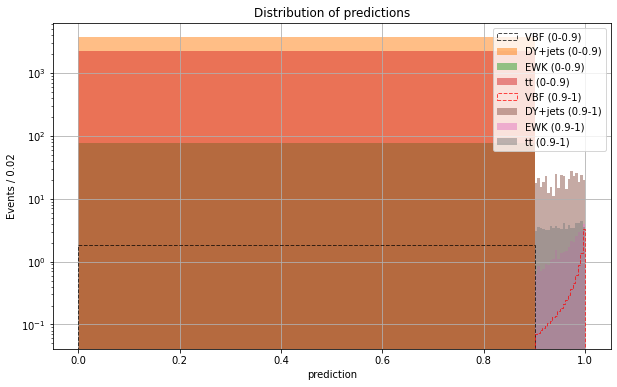

In [29]:
plt.figure(figsize=(10, 6))
bins_09 = np.array([0, 0.9])
bins_091 = np.linspace(0.9, 1, 21)
scaled_weights = df1['total_weight']


plt.hist(df1[df1['label'].str.contains("VBF")]['predictions'], 
         bins=bins_09, alpha=0.7, 
         weights=scaled_weights[df1['label'].str.contains("VBF")], 
         histtype='step', label='VBF (0-0.9)', edgecolor='black', linestyle='--')
plt.hist(df1[df1['label'].str.contains("DY")]['predictions'], 
         bins=bins_09, alpha=0.5, 
         weights=scaled_weights[df1['label'].str.contains("DY")], 
         label='DY+jets (0-0.9)')
plt.hist(df1[df1['label'].str.contains("EWK")]['predictions'], 
         bins=bins_09, alpha=0.5, 
         weights=scaled_weights[df1['label'].str.contains("EWK")], 
         label='EWK (0-0.9)')
plt.hist(df1[df1['label'].str.contains("tt")]['predictions'], 
         bins=bins_09, alpha=0.5, 
         weights=scaled_weights[df1['label'].str.contains("tt")], 
         label='tt (0-0.9)')

plt.hist(df1[df1['label'].str.contains("VBF")]['predictions'], 
         bins=bins_091, alpha=0.7, 
         weights=scaled_weights[df1['label'].str.contains("VBF")], 
         histtype='step', label='VBF (0.9-1)', edgecolor='red', linestyle='--')
plt.hist(df1[df1['label'].str.contains("DY")]['predictions'], 
         bins=bins_091, alpha=0.5, 
         weights=scaled_weights[df1['label'].str.contains("DY")], 
         label='DY+jets (0.9-1)')
plt.hist(df1[df1['label'].str.contains("EWK")]['predictions'], 
         bins=bins_091, alpha=0.5, 
         weights=scaled_weights[df1['label'].str.contains("EWK")], 
         label='EWK (0.9-1)')
plt.hist(df1[df1['label'].str.contains("tt")]['predictions'], 
         bins=bins_091, alpha=0.5, 
         weights=scaled_weights[df1['label'].str.contains("tt")], 
         label='tt (0.9-1)')

plt.xlabel('prediction')
plt.ylabel('Events / 0.02')
plt.title(f'Distribution of predictions')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
print("Finished!")
model.summary()
print(model)

Finished!


Model: "functional_103"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 33)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden1 (Dense)                 │ (None, 87)             │         2,958 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2 (Dense)                 │ (None, 44)             │         3,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden3 (Dense)                 │ (None, 22)             │           990 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden4 (Dense)                 │ (None, 11)             │           253 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,257 (94.76 KB)

 Trainable params: 8,085 (31.58 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,172 (63.18 KB)

<Functional name=functional_103, built=True>


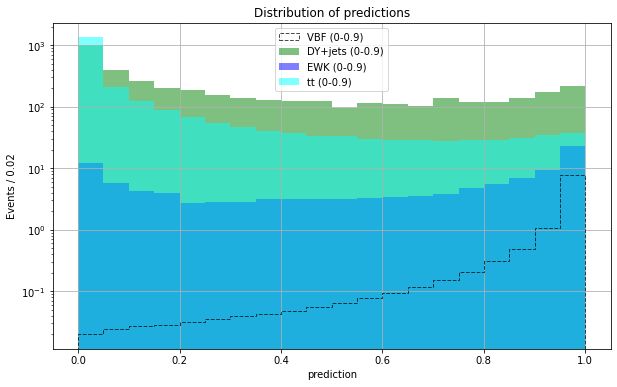

In [31]:
plt.figure(figsize=(10, 6))
bins_09 = np.linspace(0, 1, 21) 
bins_091 = np.linspace(0.9, 1, 21) 
scaled_weights = df1['total_weight']


plt.hist(df1[df1['label'].str.contains("VBF")]['predictions'], 
         bins=bins_09, alpha=0.7, 
         weights=scaled_weights[df1['label'].str.contains("VBF")], 
         histtype='step', label='VBF (0-0.9)', edgecolor='black', linestyle='--')
plt.hist(df1[df1['label'].str.contains("DY")]['predictions'], 
         bins=bins_09, alpha=0.5, 
         weights=scaled_weights[df1['label'].str.contains("DY")], 
         label='DY+jets (0-0.9)',color='green')
plt.hist(df1[df1['label'].str.contains("EWK")]['predictions'], 
         bins=bins_09, alpha=0.5, 
         weights=scaled_weights[df1['label'].str.contains("EWK")], 
         label='EWK (0-0.9)',color='blue')
plt.hist(df1[df1['label'].str.contains("tt")]['predictions'], 
         bins=bins_09, alpha=0.5, 
         weights=scaled_weights[df1['label'].str.contains("tt")], 
         label='tt (0-0.9)',color='cyan')
'''
plt.hist(df1[df1['label'].str.contains("VBF")]['predictions'], 
         bins=bins_091, alpha=0.7, 
         weights=scaled_weights[df1['label'].str.contains("VBF")], 
         histtype='step', label='VBF (0.9-1)', edgecolor='red', linestyle='--')
plt.hist(df1[df1['label'].str.contains("DY")]['predictions'], 
         bins=bins_091, alpha=0.5, 
         weights=scaled_weights[df1['label'].str.contains("DY")], 
         label='DY+jets (0.9-1)')
plt.hist(df1[df1['label'].str.contains("EWK")]['predictions'], 
         bins=bins_091, alpha=0.5, 
         weights=scaled_weights[df1['label'].str.contains("EWK")], 
         label='EWK (0.9-1)')
plt.hist(df1[df1['label'].str.contains("tt")]['predictions'], 
         bins=bins_091, alpha=0.5, 
         weights=scaled_weights[df1['label'].str.contains("tt")], 
         label='tt (0.9-1)')
'''
plt.xlabel('prediction')
plt.ylabel('Events / 0.02')
plt.title(f'Distribution of predictions')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

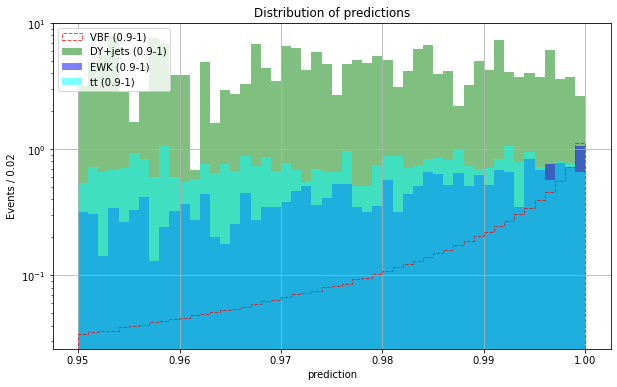

In [32]:
plt.figure(figsize=(10, 6))
bins_09 = np.array([0, 0.9]) 
bins_091 = np.linspace(0.95, 1, 51)  
scaled_weights = df1['total_weight']

plt.hist(df1[df1['label'].str.contains("VBF")]['predictions'], 
         bins=bins_091, alpha=0.7, 
         weights=scaled_weights[df1['label'].str.contains("VBF")], 
         histtype='step', label='VBF (0.9-1)', edgecolor='red', linestyle='--')
plt.hist(df1[df1['label'].str.contains("DY")]['predictions'], 
         bins=bins_091, alpha=0.5, 
         weights=scaled_weights[df1['label'].str.contains("DY")], 
         label='DY+jets (0.9-1)',color='green')
plt.hist(df1[df1['label'].str.contains("EWK")]['predictions'], 
         bins=bins_091, alpha=0.5, 
         weights=scaled_weights[df1['label'].str.contains("EWK")], 
         label='EWK (0.9-1)',color='blue')
plt.hist(df1[df1['label'].str.contains("tt")]['predictions'], 
         bins=bins_091, alpha=0.5, 
         weights=scaled_weights[df1['label'].str.contains("tt")], 
         label='tt (0.9-1)',color='cyan')

plt.xlabel('prediction')
plt.ylabel('Events / 0.02')
plt.title(f'Distribution of predictions')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()